In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# prompt: import numpy and pandas print 1

import numpy as np
import pandas as pd # cool !

df = pd.read_csv('/content/drive/MyDrive/SMAI/Q1Data.csv')
df[:5]

,MFCCs_ 1,MFCCs_ 2,MFCCs_ 3,MFCCs_ 4,MFCCs_ 5,MFCCs_ 6,MFCCs_ 7,MFCCs_ 8,MFCCs_9,MFCCs_10,...,MFCCs_15,MFCCs_16,MFCCs_17,MFCCs_18,MFCCs_19,MFCCs_20,MFCCs_21,Family,Genus,Species
0,0.152936,-0.105586,0.200722,0.317201,0.260764,0.100945,-0.150063,-0.171128,0.124676,0.188654,...,-0.024017,-0.108351,-0.077623,-0.009568,0.057684,0.118680,0.014038,Leptodactylidae,Adenomera,AdenomeraAndre
1,0.171534,-0.098975,0.268425,0.338672,0.268353,0.060835,-0.222475,-0.207693,0.170883,0.270958,...,0.012022,-0.090974,-0.056510,-0.035303,0.020140,0.082263,0.029056,Leptodactylidae,Adenomera,AdenomeraAndre
2,0.152317,-0.082973,0.287128,0.276014,0.189867,0.008714,-0.242234,-0.219153,0.232538,0.266064,...,0.083536,-0.050691,-0.023590,-0.066722,-0.025083,0.099108,0.077162,Leptodactylidae,Adenomera,AdenomeraAndre
3,0.224392,0.118985,0.329432,0.372088,0.361005,0.015501,-0.194347,-0.098181,0.270375,0.267279,...,-0.050224,-0.136009,-0.177037,-0.130498,-0.054766,-0.018691,0.023954,Leptodactylidae,Adenomera,AdenomeraAndre
4,0.087817,-0.068345,0.306967,0.330923,0.249144,0.006884,-0.265423,-0.172700,0.266434,0.332695,...,0.062837,-0.048885,-0.053074,-0.088550,-0.031346,0.108610,0.079244,Leptodactylidae,Adenomera,AdenomeraAndre


#Data Analysis

Its always best to find out first weather this data does indeed fit the criteria for a good KNN model
dataset, you would typically want to see the classes of each Genus type apart.

We will also be comparing a few MFCCs at random.




In [ ]:
class_count = df['Genus'].value_counts()
class_count

Adenomera        4150
Hypsiboas        1593
Ameerega          542
Dendropsophus     310
Leptodactylus     270
Scinax            148
Osteocephalus     114
Rhinella           68
Name: Genus, dtype: int64

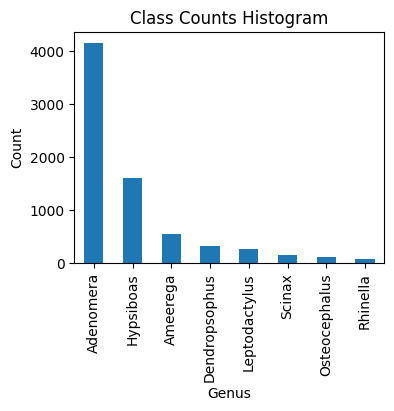

In [ ]:
#@title Histogram code
import matplotlib.pyplot as plt
def pltGenus(data):
  plt.figure(figsize=(4, 3))
  data.plot(kind='bar')
  plt.title('Class Counts Histogram')
  plt.xlabel('Genus')
  plt.ylabel('Count')
  plt.show()

pltGenus(class_count)

The data does appear to be very skewed towards Adenomera, lets extract 30% of the dataset for testing (and 10% for training) before analysing further.

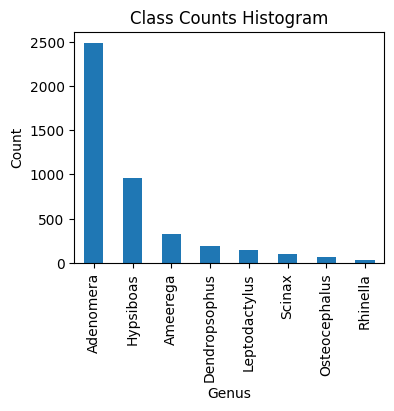

Adenomera        2486
Hypsiboas         962
Ameerega          321
Dendropsophus     195
Leptodactylus     150
Scinax             99
Osteocephalus      71
Rhinella           33
Name: Genus, dtype: int64

In [ ]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.1, train_size=0.3, random_state=42)
new_df = df.loc[~df.index.isin(train_df.index) & ~df.index.isin(test_df.index)]
pltGenus(new_df['Genus'].value_counts())
new_df['Genus'].value_counts()

Since we are not at the stage of devising algorithms (or even using them) to manipulate skewed today, we decide to look at several evaluation metrics such as the f1-score.
Diving deeper into the data analysis part, lets see how sparse the data is or how clustered it is.

In [ ]:
#@title Scatterplot since are using KNN
import seaborn as sns

def plot_mfccs_sample(df, genus_values, mfcc1, mfcc2, sample_size=100):
    sample_df = df.sample(n=sample_size, random_state=42)  # Change the random_state as needed
    plt.figure(figsize=(12, 3))
    sns.scatterplot(x=sample_df[mfcc1], y=sample_df[mfcc2], hue=sample_df['Genus'], palette='viridis', alpha=0.7, s=60)
    plt.title(f'Scatter Plot of {mfcc1} vs {mfcc2}')
    plt.xlabel(mfcc1)
    plt.ylabel(mfcc2)
    plt.legend(title='Genus', labels=genus_values, loc='upper right', fontsize='small')
    plt.show()

genus_values = new_df['Genus'].unique() # get the unique labels


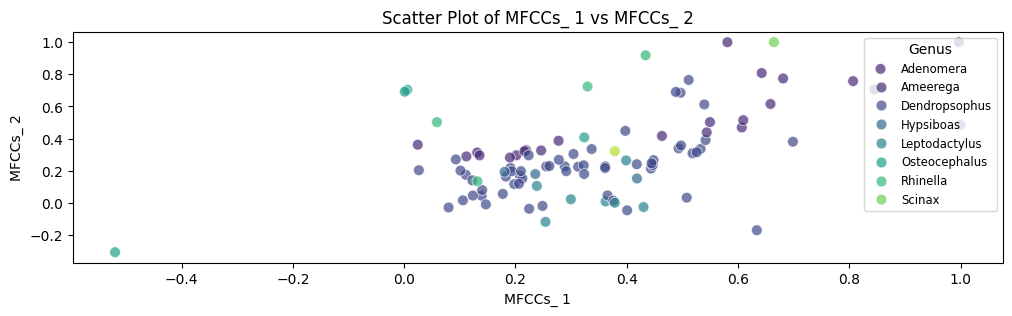

In [ ]:
plot_mfccs_sample(new_df, genus_values, 'MFCCs_ 1', 'MFCCs_ 2')

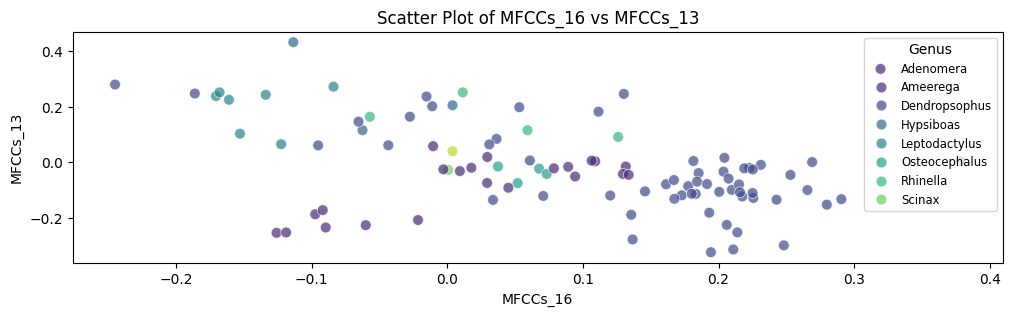

In [ ]:
plot_mfccs_sample(new_df, genus_values, 'MFCCs_16', 'MFCCs_13')

There does indeed seem to be some sort of clustering, lets build our model now.

In [ ]:
#@title KNN Class
class KNN:

    def __init__(self, k=3, X_train=None, Y_train=None):
        self.k = k
        self.X_train = X_train
        self.Y_train = Y_train

    def fit(self, X, Y):
        self.X_train = X
        self.Y_train = Y

    def get_euclidean_distance(self, p1, p2):
        return np.sqrt(np.sum((np.asarray(p1, dtype=float) - np.asarray(p2, dtype=float)) ** 2))

    def get_label(self, index):
        return self.Y_train[index]

    def get_output(self, data_points_index):
        labels = [self.get_label(i) for i in data_points_index]
        mode = max(set(labels), key=labels.count)
        return mode

    def make_prediction(self, data):
        distances = [float(self.get_euclidean_distance(x, data)) for x in self.X_train]
        sorted_index = np.argsort(distances)
        k_closest_data_points = sorted_index[:self.k]
        prediction = self.get_output(k_closest_data_points)
        return prediction

    def predict(self, X):
        if self.X_train is None or self.Y_train is None:
            return
        return np.array([self.make_prediction(x) for x in X])


In [ ]:
from sklearn.metrics import accuracy_score, f1_score
import time

X_train, Y_train = train_df.drop(columns=['Genus', 'Family','Species']), train_df['Genus']
X_test = test_df.drop(columns=['Genus', 'Family','Species'])
acc, time_taken, f1_metric = [], [], []
for k in range(1, 51):
  model = KNN(k)
  start = time.time()
  model.fit(X_train.values, Y_train.values)
  predictions = model.predict(X_test.values)
  tt = time.time() - start
  time_taken.append(tt)
  accuracy = accuracy_score(test_df['Genus'], predictions)
  f1 = f1_score(test_df['Genus'], predictions, average='weighted')

  acc.append(accuracy)
  f1_metric.append(f1)
  print(f"For k: {k}, time: {tt}, acc: {accuracy}, f1: {f1}")


For k: 1, time: 23.628674745559692, acc: 0.9847222222222223, f1: 0.9846604560438214
For k: 2, time: 12.720430374145508, acc: 0.9805555555555555, f1: 0.979772843443032
For k: 3, time: 12.73792576789856, acc: 0.9791666666666666, f1: 0.978198111414052
For k: 4, time: 12.378337621688843, acc: 0.9763888888888889, f1: 0.9749969776673493
For k: 5, time: 12.220176219940186, acc: 0.9763888888888889, f1: 0.9749969776673493
For k: 6, time: 12.861597537994385, acc: 0.9736111111111111, f1: 0.9724447757780502
For k: 7, time: 14.819370746612549, acc: 0.9722222222222222, f1: 0.9707861878983641
For k: 8, time: 13.433510303497314, acc: 0.9708333333333333, f1: 0.9694453864339873
For k: 9, time: 13.02232027053833, acc: 0.9652777777777778, f1: 0.9636880606119852
For k: 10, time: 13.428595066070557, acc: 0.9652777777777778, f1: 0.9634908407676966
For k: 11, time: 12.224189281463623, acc: 0.9625, f1: 0.9601869886774849
For k: 12, time: 12.54191517829895, acc: 0.9611111111111111, f1: 0.9582290527253261
For k:

In [ ]:
# check for k = 42 for overfitting
model = KNN(42)
model.fit(X_train.values, Y_train.values)
predictions = model.predict(X_train.values)
predictions.shape

(2158,)

In [ ]:
accuracy = accuracy_score(train_df['Genus'], predictions)
accuracy

0.9267840593141798

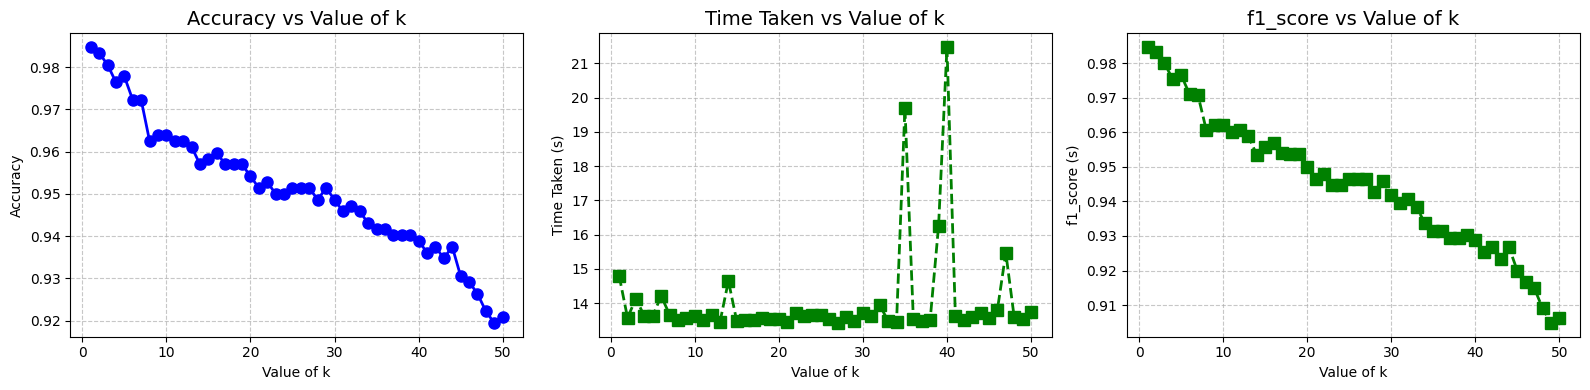

In [ ]:
#@title Plotting the graph for KNN (k = 1-1000)

import matplotlib.pyplot as plt

plt.figure(figsize = (16, 4))
plt.subplot(1, 3, 1)
plt.plot(range(1, 51), acc, marker='o', color='blue', linestyle='-', linewidth=2, markersize=8)
plt.xlabel("Value of k")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Value of k", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)

plt.subplot(1, 3, 2)
plt.plot(range(1, 51), time_taken, marker='s', color='green', linestyle='--', linewidth=2, markersize=8)
plt.xlabel("Value of k")
plt.ylabel("Time Taken (s)")
plt.title("Time Taken vs Value of k", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)

plt.subplot(1, 3, 3)
plt.plot(range(1, 51), f1_metric, marker='s', color='green', linestyle='--', linewidth=2, markersize=8)
plt.xlabel("Value of k")
plt.ylabel("f1_score (s)")
plt.title("f1_score vs Value of k", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
acc[-5:-1], f1_metric[-5:-1]

([0.9291666666666667,
  0.9263888888888889,
  0.9222222222222223,
  0.9194444444444444],
 [0.916562640924351,
  0.9149727076367611,
  0.9090304519346741,
  0.9048283482195638])

# Obesrvations:
- The dataset seems to be in a good condition for using a KNN approach
- The accuracy value on the training dataset did decrease from `99%` to approx `92%`  on increasing `k` while we do see a  few bumps between the range `40-45`.
- Time taken to train for some values of `k` spikes up
- `f1` scores seem to decline as well with higher values of `k`
- For value of `k=42` the model gives us an accuracy of `92%` on the training dataset indicating that it is not overfitting afterall.